# Light GBM

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!git clone --recursive https://github.com/Microsoft/LightGBM ;

fatal: destination path 'LightGBM' already exists and is not an empty directory.


In [4]:
%cd /content/LightGBM

/content/LightGBM


In [5]:
!mkdir build
!cmake -DUSE_GPU=1 #avoid ..
!make -j$(nproc)

mkdir: cannot create directory ‘build’: File exists
-- OpenCL include directory: /usr/include
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--   filesystem
--   system
-- Using _mm_prefetch
-- Using _mm_malloc
-- Configuring done
-- Generating done
-- Build files have been written to: /content/LightGBM
[100%] Built target _lightgbm
[100%] Built target lightgbm


In [6]:
!sudo apt-get -y install python-pip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-pip is already the newest version (9.0.1-2.3~ubuntu1.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [7]:
!sudo -H pip install setuptools pandas numpy scipy scikit-learn mlflow datetime matplotlib -U

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (46.1.3)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.0.3)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.18.4)
Requirement already up-to-date: scipy in /usr/local/lib/python3.6/dist-packages (1.4.1)
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22.2.post1)
Requirement already up-to-date: mlflow in /usr/local/lib/python3.6/dist-packages (1.8.0)
Requirement already up-to-date: datetime in /usr/local/lib/python3.6/dist-packages (4.3)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.2.1)


In [8]:
%cd /content/LightGBM/python-package

/content/LightGBM/python-package


In [9]:
!sudo python setup.py install --precompile

running install
running build
running build_py
INFO:root:Generating grammar tables from /usr/lib/python3.6/lib2to3/Grammar.txt
INFO:root:Generating grammar tables from /usr/lib/python3.6/lib2to3/PatternGrammar.txt
running egg_info
writing lightgbm.egg-info/PKG-INFO
writing dependency_links to lightgbm.egg-info/dependency_links.txt
writing requirements to lightgbm.egg-info/requires.txt
writing top-level names to lightgbm.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
no previously-included directories found matching 'build'
writing manifest file 'lightgbm.egg-info/SOURCES.txt'
running install_lib
INFO:LightGBM:Installing lib_lightgbm from: ['../lib_lightgbm.so']
running install_egg_info
removing '/usr/local/lib/python3.6/dist-packages/lightgbm-2.3.2-py3.6.egg-info' (and everything under it)
Copying lightgbm.egg-info to /usr/local/lib/python3.6/dist-packages/lightgbm-2.3.2-py3.6.egg-info
running install_scripts


Use tree-based algorithms since they are powerful and do not impose strict assumptions on features like linearity or independence. Light GBM is a fast algorithm with lower memory usage.

In [0]:
#!pip install mlflow

In [0]:
#conda install numpy

Import libraries

In [12]:
import pandas as pd
import numpy as np
from datetime  import datetime  
from datetime import timedelta  
import lightgbm as lgb
from sklearn import preprocessing, metrics
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.lightgbm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Read data

In [0]:
data_folder = '/content/drive/My Drive/Kaggle_M5/01_preprocessed_data/'
X_train = pd.read_pickle(data_folder + 'X_train.pkl')
X_val = pd.read_pickle(data_folder +  'X_val.pkl')
X_test = pd.read_pickle(data_folder + 'X_test.pkl')
y_train = X_train['demand']
y_val = X_val['demand']


In [0]:
data_folder = '/content/drive/My Drive/Kaggle_M5/00_data/'
submission = pd.read_csv(data_folder + 'sample_submission.csv')

Set parameters of the light GBM and select features to fit.

In [15]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)

(44105308, 44)
(853720, 44)
(853720, 44)
(44105308,)
(853720,)


In [0]:
params = {
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'objective':  'poisson',
        'n_jobs': -1,
        'seed': 0,
        'learning_rate': 0.1, 
        'bagging_fraction': 0.75,
        'bagging_freq': 10, 
        'colsample_bytree': 0.75, 
        'num_iterations':2000,
        'device': 'gpu'}
not_features = ['d', 'id', 'item_id', 'demand', 'date', 'start_date']

In [0]:
params = {'bagging_fraction': 0.5, 
          'bagging_freq': 10, 
          'boosting_type': 'gbdt', 
          'colsample_bytree': 0.75, 
          'device': 'gpu', 
          'early_stopping_round': 500, 
          'learning_rate': 0.05, 
          'metric': 'rmse', 
          'n_jobs': -1, 
          'num_iterations': 5000, 
          'objective': 'tweedie', 
          'seed': 0}

In [0]:
param_grid = {'boosting_type': ['gbdt'],
        'metric': ['rmse'],
        'objective': ['poisson', 'tweedie'],
        'n_jobs': [-1],
        'seed': [0],
        'learning_rate':  [0.05, 0.075, 0.1],
        'bagging_fraction': [0.5, 0.75, 1],
        'bagging_freq': [10], 
        'colsample_bytree': [0.75],
        'num_iterations': [1000, 5000],
        'early_stopping_round': [500],
        'device': ['gpu']}

In [0]:
features = X_test.columns[~X_test.columns.isin(not_features)]

In [19]:
X_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,weekday,month,event_name_1,event_type_1,year,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,start_date,days_from_start,start_date_from_start,sell_price,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,rmean_28_3,rmean_28_7,ADI,CV2,demand_type,avg_weekday_demand,avg_demand,max_demand,std_demand,quantile025_week,max_weekday_demand,avg_price,cheaper_than_usual
428807,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_36,0,2011-03-05,Saturday,3,no event,no event,2011,no event,no event,1,1,1,2011-01-29,35,0,0.419922,5.0,6.0,4.0,0.0,0.0,0.0,15.0,12.0,5.000000,4.285156,1.385742,0.858398,lumpy,8.570312,7.285156,91,9.140625,1.0,47,0.476807,True
428808,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_36,7,2011-03-05,Saturday,3,no event,no event,2011,no event,no event,1,1,1,2011-01-29,35,0,1.559570,9.0,3.0,2.0,0.0,3.0,7.0,0.0,2.0,4.667969,3.427734,2.181641,0.798340,lumpy,1.463867,1.174805,20,2.007812,0.0,10,1.767578,True
428809,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_36,0,2011-03-05,Saturday,3,no event,no event,2011,no event,no event,1,1,1,2011-01-29,35,0,3.169922,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.142822,2.054688,0.267822,intermittent,0.826172,0.730469,6,0.925781,0.0,5,2.978516,False
428810,HOBBIES_1_012_CA_1_validation,HOBBIES_1_012,HOBBIES_1,HOBBIES,CA_1,CA,d_36,1,2011-03-05,Saturday,3,no event,no event,2011,no event,no event,1,1,1,2011-01-29,35,0,5.980469,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.666504,0.571289,3.183594,0.157715,intermittent,0.486816,0.394043,3,0.645996,0.0,3,6.476562,True
428811,HOBBIES_1_015_CA_1_validation,HOBBIES_1_015,HOBBIES_1,HOBBIES,CA_1,CA,d_36,1,2011-03-05,Saturday,3,no event,no event,2011,no event,no event,1,1,1,2011-01-29,35,0,0.720215,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.000000,0.714355,1.237305,0.986328,erratic,8.757812,6.128906,83,7.398438,3.0,52,0.707031,False


In [0]:
X_train = X_train[X_train['date'] >= "2015-01-01"]
y_train = X_train['demand']


In [0]:
train_set = lgb.Dataset(X_train[features], y_train) #, categorical_feature = categorical_features)
val_set = lgb.Dataset(X_val[features], y_val)#,  categorical_feature = categorical_features)

Train the model

In [0]:
#print(X_train.dtypes)

In [23]:
model = lgb.train(params, train_set,  
                  valid_sets = [train_set, val_set], verbose_eval = 100)

/content/LightGBM/python-package/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/content/LightGBM/python-package/lightgbm/basic.py:1117: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/content/LightGBM/python-package/lightgbm/basic.py:929: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[100]	training's rmse: 2.28871	valid_1's rmse: 2.23278
[200]	training's rmse: 2.21928	valid_1's rmse: 2.18815
[300]	training's rmse: 2.17797	valid_1's rmse: 2.18278
[400]	training's rmse: 2.14603	valid_1's rmse: 2.17284
[500]	training's rmse: 2.12326	valid_1's rmse: 2.17587
[600]	training's rmse: 2.10169	valid_1's rmse: 2.1725
[700]	training's rmse: 2.08406	valid_1's rmse: 2.17212
[800]	training's rmse: 2.07021	valid_1's rmse: 2.17952
[900]	training's rmse: 2.05767	valid_1's rmse: 2.18299
[1000]	training's rmse: 2.04617	valid_1's rmse: 2.17978
[1100]	training's rmse: 2.03322	valid_1's rmse: 2.17767
[1200]	training's rmse: 2.02369	valid_1's rmse: 2.17744
[1300]	training's rmse: 2.01581	valid_1's rmse: 2.18408
[1400]	training's rmse: 2.00541	valid_1's rmse: 2.18808
[1500]	training's rmse: 1.99655	valid_1's rmse: 2.18578
[1600]	training's rmse: 1.98833	valid_1's rmse: 2.18728
[1700]	training's rmse: 1.98031	valid_1's rmse: 2.1866
[1800]	training's rmse: 1.9726	valid_1's rmse: 2.18545
[190

In [24]:
i = 0
data_folder = '/content/drive/My Drive/Kaggle_M5/04_submissions/'
for g in ParameterGrid(param_grid):
    print(i)
    print(g)
    mlflow.lightgbm.autolog() 
    model = lgb.train(g, train_set,  
                  valid_sets = [train_set, val_set], verbose_eval = 100)
    
    y_test = model.predict(X_test[features])
    X_test['demand'] = y_test

    predictions = X_test[['id', 'days_from_start', 'demand']]
    predictions = pd.pivot(predictions, index = 'id', columns = 'days_from_start', values = 'demand').reset_index()
    predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

    evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
    evaluation = submission[submission['id'].isin(evaluation_rows)]

    validation = submission[['id']].merge(predictions, on = 'id')
    final = pd.concat([validation, evaluation])
    final.head()
    final.to_csv(data_folder + 'lightGBM.csv', index = False)
    final.to_csv(data_folder + 'lightGBM_{}.csv'.format(i), index = False)
    i = i + 1
    print("------------------------------------")

0
{'bagging_fraction': 0.5, 'bagging_freq': 10, 'boosting_type': 'gbdt', 'colsample_bytree': 0.75, 'device': 'gpu', 'early_stopping_round': 500, 'learning_rate': 0.05, 'metric': 'rmse', 'n_jobs': -1, 'num_iterations': 1000, 'objective': 'poisson', 'seed': 0}


/usr/local/lib/python3.6/dist-packages/mlflow/utils/autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505
/usr/local/lib/python3.6/dist-packages/mlflow/lightgbm.py:285: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_arg_names = inspect.getargspec(original)[0]  # pylint: disable=W1505
/content/LightGBM/python-package/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/content/LightGBM/python-package/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".form

Training until validation scores don't improve for 500 rounds
[100]	training's rmse: 2.30674	valid_1's rmse: 2.22647
[200]	training's rmse: 2.26263	valid_1's rmse: 2.1925
[300]	training's rmse: 2.23111	valid_1's rmse: 2.17507
[400]	training's rmse: 2.20408	valid_1's rmse: 2.16892
[500]	training's rmse: 2.17884	valid_1's rmse: 2.16208
[600]	training's rmse: 2.15798	valid_1's rmse: 2.15934
[700]	training's rmse: 2.14161	valid_1's rmse: 2.15281
[800]	training's rmse: 2.13051	valid_1's rmse: 2.1596
[900]	training's rmse: 2.11793	valid_1's rmse: 2.16028
[1000]	training's rmse: 2.1054	valid_1's rmse: 2.15784
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 2.1054	valid_1's rmse: 2.15784
------------------------------------
1
{'bagging_fraction': 0.5, 'bagging_freq': 10, 'boosting_type': 'gbdt', 'colsample_bytree': 0.75, 'device': 'gpu', 'early_stopping_round': 500, 'learning_rate': 0.05, 'metric': 'rmse', 'n_jobs': -1, 'num_iterations': 1000, 'objective': 'tweedie', 's

LightGBMError: ignored

In [0]:
print(len(ParameterGrid(param_grid)))

18


Calculate the RMSE on the validation set

In [0]:
y_test = model.predict(X_test[features])

In [31]:
val_pred = model.predict(X_val[features])
val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_val))
X_val['demand'] = y_val
X_val['demand_pred'] = val_pred
X_val['abs_difference'] = abs(X_val['demand'] - X_val['demand_pred'])
print(f'Our val rmse score is {val_score}')
y_test = model.predict(X_test[features])
X_test['demand'] = y_test


Our val rmse score is 2.1670413807487776


In [32]:
print(f'Our val mae score is {metrics.mean_absolute_error(val_pred, y_val)}')

Our val mae score is 1.064301236515293


We look at the mean absolute error by forecastablity in order to indestand what category needs more improvement for prediction.

In [33]:
X_val.groupby(['demand_type'])['demand_type', 'abs_difference'].agg(['mean']).reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,demand_type,abs_difference
,,mean
0,0,0.902455
1,erratic,3.403389
2,intermittent,0.717328
3,lumpy,1.565815
4,smooth,2.801362


Text(0.5, 0, 'absolute error')

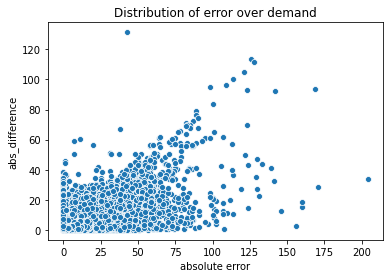

In [34]:
demans_vs_error = sns.scatterplot(x=X_val['demand'], y=X_val['abs_difference'])
demans_vs_error.set_title('Distribution of error over demand')
demans_vs_error.set_xlabel('absolute error')

Surprisingly smooth time series has a large mean absolute error. Erratic time series has a large mean absolute error; typically time series of this type is difficult to predict.

## Feature importance

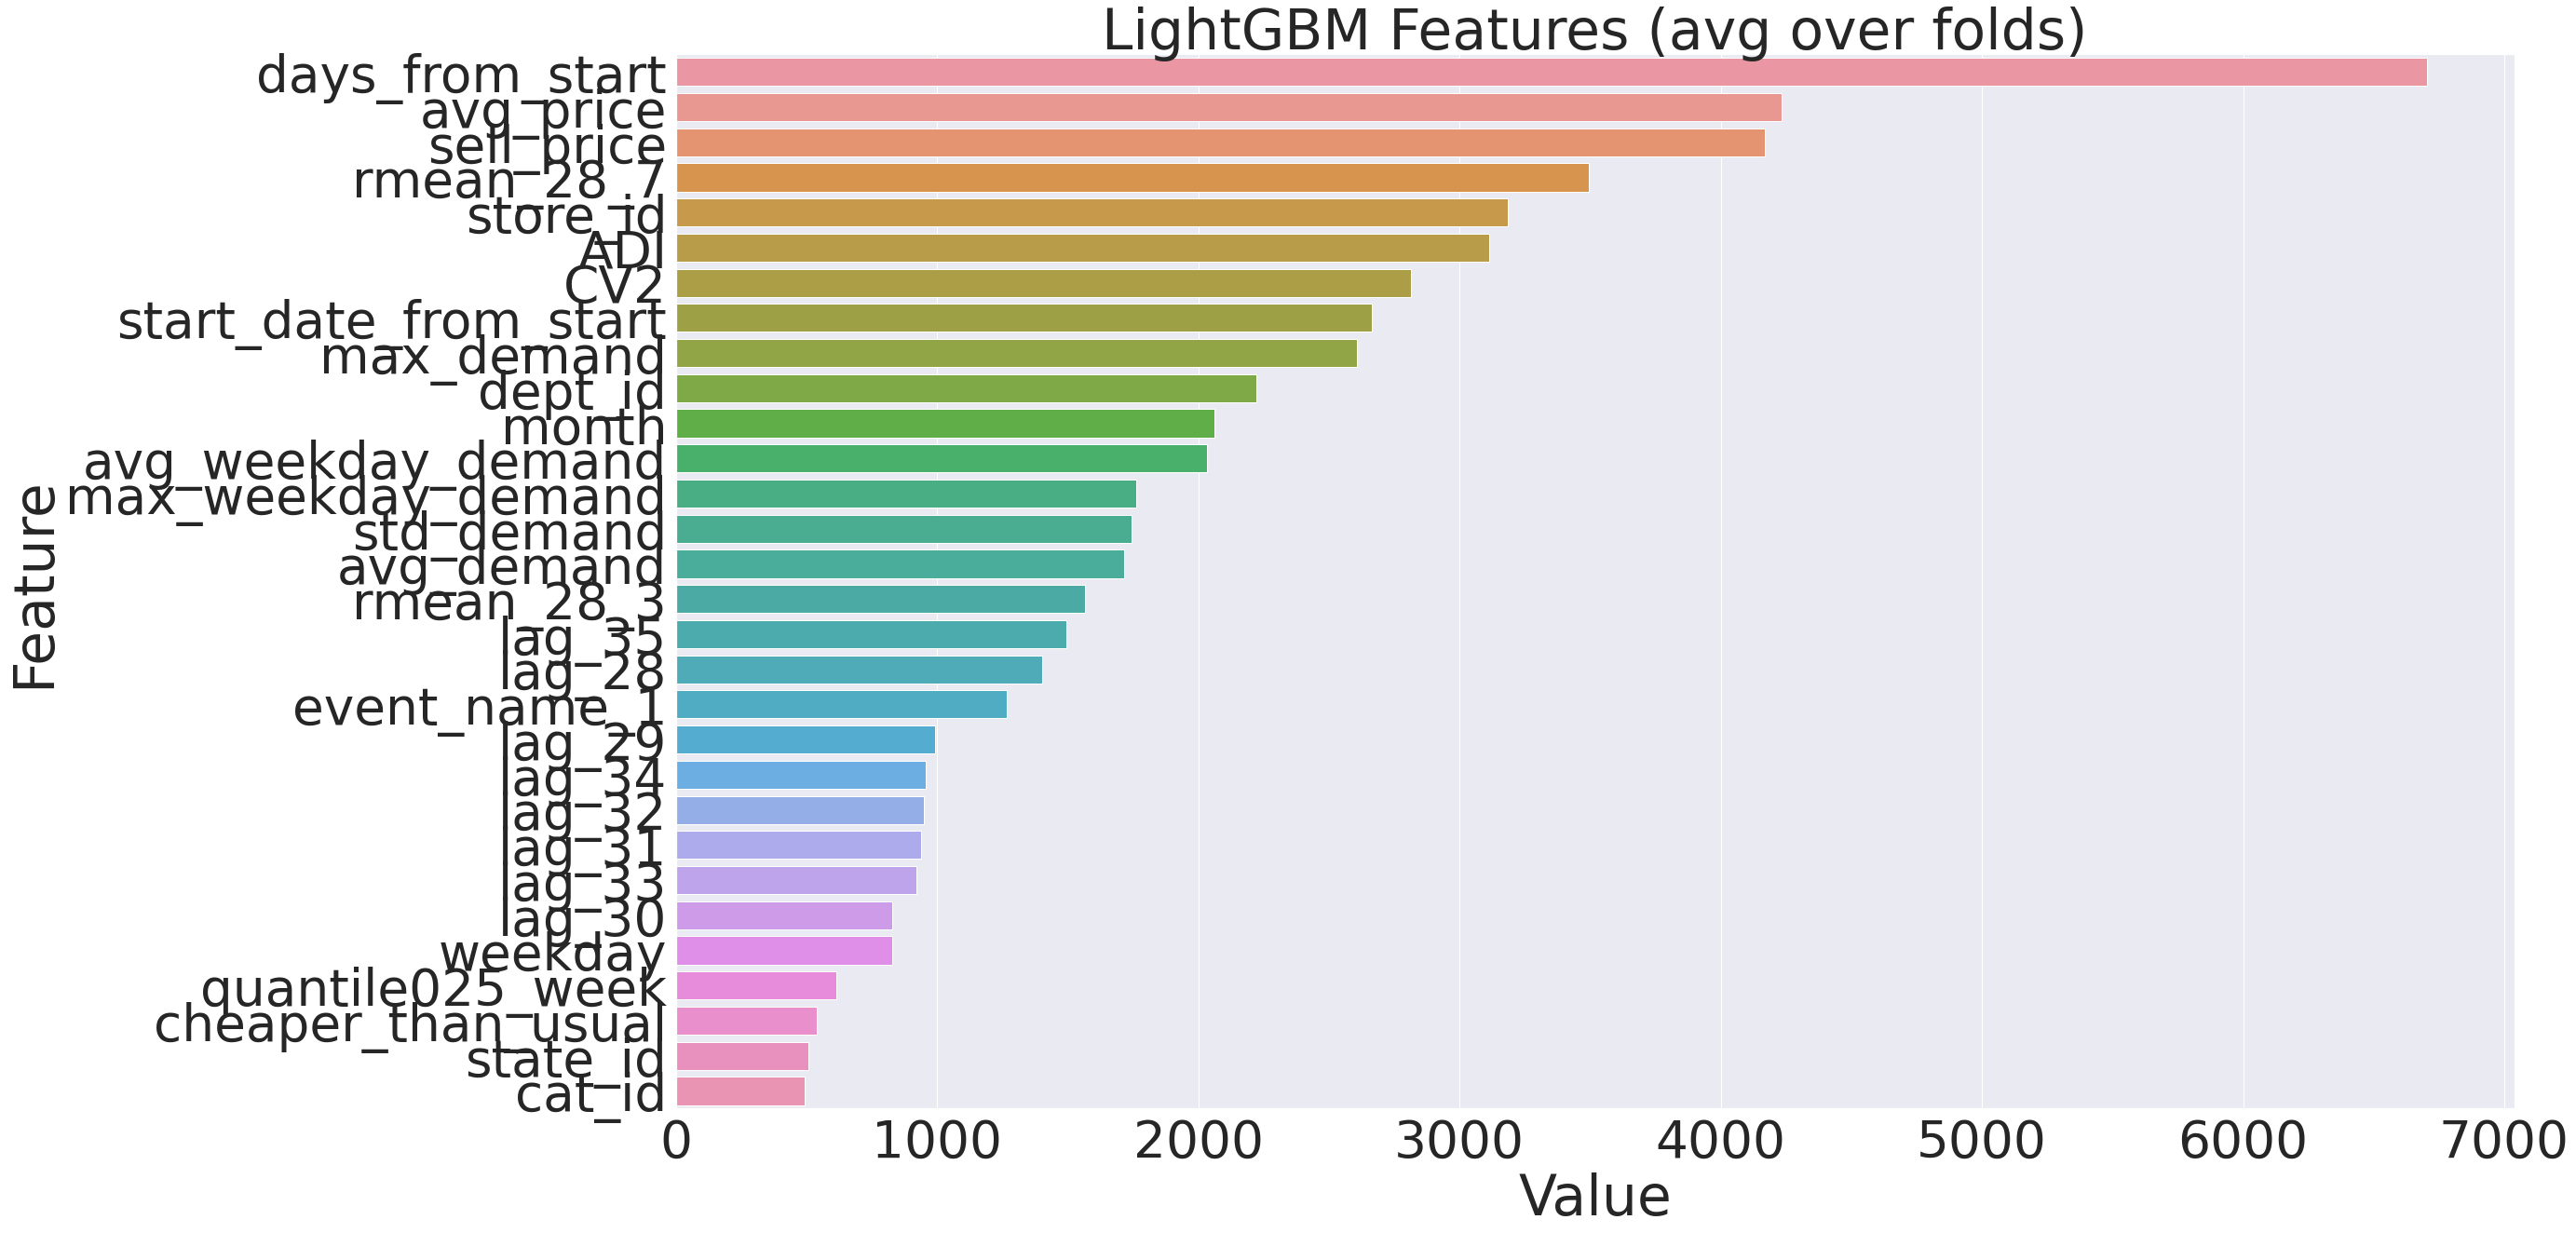

In [35]:
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()
plotImp(model, X_train[features], 30)

'item_id' and 'id' are most important features. 'days_from_start' reflect the trend of data. 

## Transform prediction

Transform predictions to the right format

In [36]:
predictions = X_test[['id', 'days_from_start', 'demand']]
predictions = pd.pivot(predictions, index = 'id', columns = 'days_from_start', values = 'demand').reset_index()
predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
evaluation = submission[submission['id'].isin(evaluation_rows)]

validation = submission[['id']].merge(predictions, on = 'id')
final = pd.concat([validation, evaluation])
final.head()


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.690058,0.756166,0.506678,0.443369,0.574863,0.804272,0.621334,0.512695,0.682156,0.563065,0.586526,0.778125,1.171879,0.934010,0.798848,0.850178,0.556909,0.487124,0.614526,1.048450,0.755817,0.626190,0.754338,0.567648,0.622604,0.769295,1.116728,0.803339
1,HOBBIES_1_002_CA_1_validation,0.319041,0.320369,0.332386,0.389947,0.377834,0.437123,0.325596,0.208220,0.173065,0.182348,0.217180,0.222143,0.288298,0.223549,0.175075,0.172699,0.181262,0.220311,0.221019,0.281694,0.232291,0.172714,0.170986,0.244405,0.292439,0.296070,0.387648,0.302530
2,HOBBIES_1_003_CA_1_validation,0.273260,0.297892,0.280508,0.306482,0.367899,0.473569,0.338761,0.251350,0.281557,0.256879,0.314453,0.377680,0.611185,0.358035,0.242890,0.269853,0.290696,0.362255,0.449678,0.763690,0.541264,0.370383,0.442780,0.423184,0.468034,0.561130,0.869509,0.518031
3,HOBBIES_1_004_CA_1_validation,1.894771,1.365470,1.320690,1.555709,1.527002,2.297133,2.614312,1.109453,1.080148,1.035023,1.338406,1.482830,2.479843,3.102989,1.669027,1.293910,1.251240,1.545840,1.623473,2.249205,2.940286,1.451563,1.180829,1.137735,1.383197,1.513090,2.728361,3.577905
4,HOBBIES_1_005_CA_1_validation,0.858905,0.724008,0.876744,1.028919,1.113309,1.541385,1.712992,1.107748,1.100008,1.139938,1.030989,0.992411,1.492916,1.322635,0.870455,0.789570,0.890612,0.906974,1.054931,1.508594,1.475675,0.899427,0.814827,0.940289,0.998273,1.130083,1.637941,1.751035


Save the submission, the features and the score to files.

In [0]:
data_folder = '/content/drive/My Drive/Kaggle_M5/04_submissions/'
final.to_csv(data_folder + 'lightGBM.csv', index = False)

In [0]:
_features = X_test.columns[~X_test.columns.isin(not_features)]
features = features.to_list()
features.append(str(val_score))
features.append(str(params['objective']))


In [0]:
with open("../04_submissions/lgb_features_score.txt", "a") as outfile:
    outfile.write("\n".join(features))


## Score

The score of this submission is 0.58584, which is better than naive prediction.